# アドバンスドビジョンレポート
## Cannyエッジ検出の実装

本レポートでは、OpenCVの画像処理ライブラリを使用せずにゼロから実装するものである。
### ライブラリの読み込み

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as m_img

### 写真の読み込みと表示

image shape: (540, 960, 3)


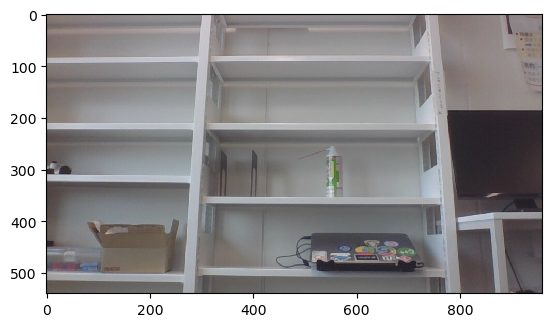

In [3]:
image = m_img.imread('background.jpg')

plt.imshow(image)
print('image shape:', image.shape)

### RGB画像をグレースケール化

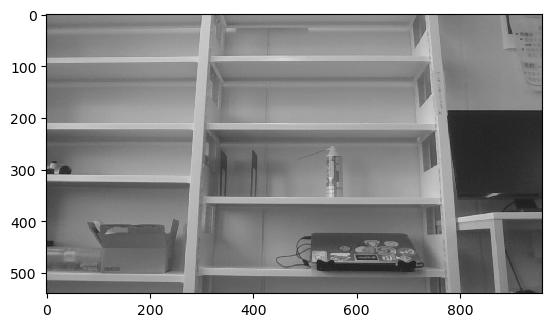

In [4]:
img_height, img_width, _ = image.shape
gray_image = np.zeros((img_height, img_width))

red_image = image[:,:,0]
green_image = image[:,:,1]
blue_image = image[:,:,2]

gray_image = (red_image*0.299) + (green_image*0.587) + (blue_image*0.114)

plt.imshow(gray_image, cmap='gray', vmin=0.0, vmax=255.0)

### 5x5ガウシアンフィルタで写真のノイズを除去

(540, 960)


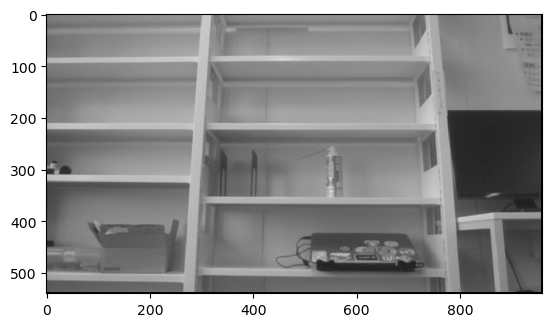

In [5]:
gausian_filter = (np.array([[1,4,7,4,1],
                           [4,16,26,16,4],
                           [7,26,41,26,7],
                           [4,16,26,16,4],
                           [1,4,7,4,1]]))/273

smooth_gray_image = np.zeros(gray_image.shape)

for h in range(2, img_height-2):
    for w in range(2, img_width-2):
        smooth_gray_image[h, w] = (gray_image[h-2:h+3, w-2:w+3] * gausian_filter).sum()

print(smooth_gray_image.shape)
plt.imshow(smooth_gray_image, cmap='gray', vmin=0.0, vmax=255.0)

### Sobelフィルターで画像の縦と横軸をそれぞれ1次微分を行い、画像の輝度の勾配を計算する

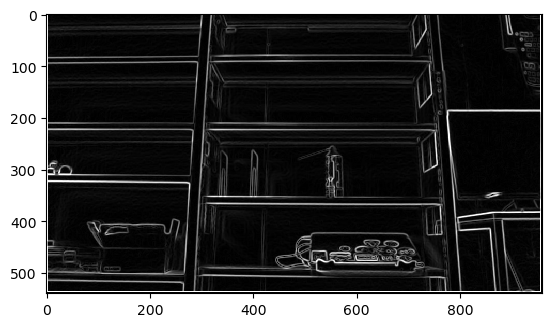

In [6]:
sobel_row = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])
sobel_col = np.array([[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]])

image_gradient_intensity = np.zeros(smooth_gray_image.shape)
image_gradient_angle = np.zeros(smooth_gray_image.shape)

for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        gradient_row = (smooth_gray_image[row-1:row+2, col-1:col+2] * sobel_row).sum()
        gradient_col = (smooth_gray_image[row-1:row+2, col-1:col+2] * sobel_col).sum()
        image_gradient_intensity[row, col] = np.sqrt(gradient_row**2 + gradient_col**2)
        image_gradient_angle[row, col] = np.arctan2(gradient_col, gradient_row)

plt.imshow(image_gradient_intensity, cmap='gray', vmin=0.0, vmax=255.0)

### 非極大値の抑制

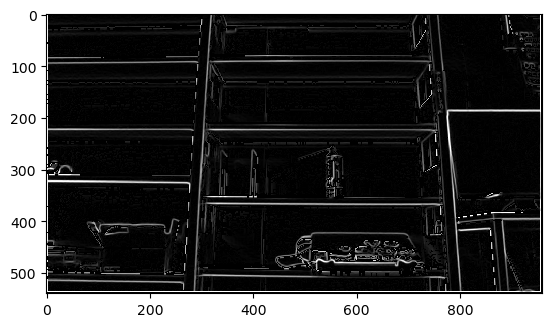

In [7]:
for row in range(1, img_height-1):
    for col in range(1, img_width-1):
        # 縦エッジ
        if (abs(image_gradient_angle[row, col]) <= np.radians(22.5)):
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row, col-1]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row, col+1]):
                image_gradient_intensity[row, col] = 0.0
        # 横エッジ
        elif np.radians(67.5) < image_gradient_angle[row, col] <= np.radians(112.5):
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row-1, col]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row+1, col]):
                image_gradient_intensity[row, col] = 0.0
        # 右斜め上と左斜め下エッジ
        elif (np.radians(22.5) < image_gradient_angle[row, col] <= np.radians(67.5)):
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row-1, col-1]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row+1, col+1]):
                image_gradient_intensity[row, col] = 0.0            
        # 右斜め下と左斜め上エッジ
        elif (np.radians(112.5) < image_gradient_angle[row, col] <= np.radians(157.5)):            
            if (image_gradient_intensity[row, col] < image_gradient_intensity[row-1, col+1]) or (image_gradient_intensity[row, col] < image_gradient_intensity[row+1, col-1]):
                image_gradient_intensity[row, col] = 0.0

plt.imsave('non-maxima-supp.jpg', image_gradient_intensity)
plt.imshow(image_gradient_intensity, cmap='gray', vmin=0.0, vmax=255.0)

### ヒステリシスしきい値処理

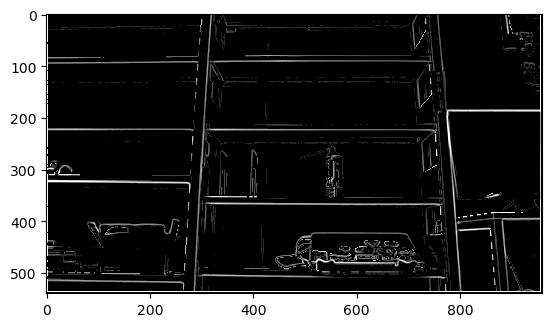

In [8]:
low_threshold = 30
high_threshold = 150

l_image = np.zeros(image_gradient_intensity.shape)
h_image = np.zeros(image_gradient_intensity.shape)
hys_image = np.zeros(image_gradient_intensity.shape)

for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        if image_gradient_intensity[row, col] > high_threshold:
            h_image[row, col] = image_gradient_intensity[row, col]

for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        if image_gradient_intensity[row, col] > low_threshold:
            l_image[row, col] = image_gradient_intensity[row, col]

# 低いしきい値
plt.imsave('low-hysterasis.jpg', l_image)
plt.imshow(l_image, cmap='gray', vmin=0.0, vmax=255.0)

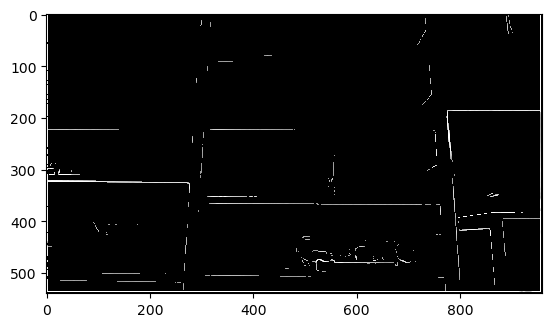

In [9]:
# 高いしきい値
plt.imsave('high-hysterasis.jpg', h_image)
plt.imshow(h_image, cmap='gray', vmin=0.0, vmax=255.0)

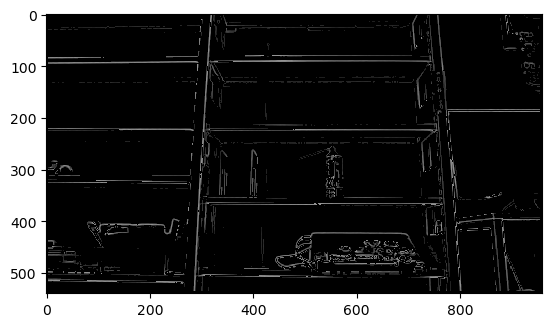

In [14]:
# ヒステリシスしきい値処理
for row in range(1, img_height-1, 1):
    for col in range(1, img_width-1, 1):
        if low_threshold < image_gradient_intensity[row, col] < high_threshold:
            hys_image[row, col] = image_gradient_intensity[row, col]

plt.imsave('hysterasis.jpg', hys_image)
plt.imshow(hys_image, cmap='gray', vmin=0.0, vmax=255.0)

### OpenCVライブラリを用いたCannyエッジ検出との比較

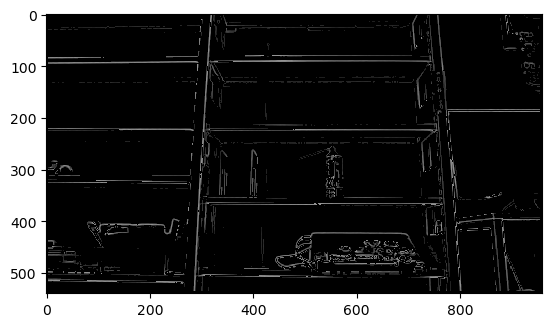

In [15]:
# 本レポートで実装したCannyエッジ検出画像            
plt.imshow(hys_image, cmap='gray', vmin=0.0, vmax=255.0)

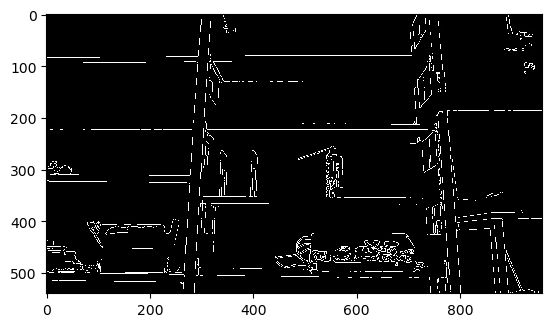

In [16]:
# OpenCVのCannyエッジ検出画像
opencv_image = m_img.imread('opencv_canny_edge.jpg')
plt.imshow(opencv_image, cmap='gray', vmin=0.0, vmax=255.0)